In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import re
import tensorflow as tf
from collections import Counter

In [2]:
def lstm_model(vocab_size, embedding_vector_length, input_length, mask_val):
    bi_directional = tf.keras.layers.Bidirectional
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Masking(mask_val, input_shape=[input_length]))
    model.add(tf.keras.layers.Embedding(vocab_size, embedding_vector_length, input_length=input_length))
    model.add(bi_directional(tf.keras.layers.LSTM(100, return_sequences=False)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

In [3]:
file_name = r"IMDB Dataset.csv"
data = pd.read_csv(file_name)
data1 = data["review"]
labels = data["sentiment"]
label_enc = sklearn.preprocessing.LabelEncoder()
labels = label_enc.fit_transform(labels)

In [4]:
contractions = {
                "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
               "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
               "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
               "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
               "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
               "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
               "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
               "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
               "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
               "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
               "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
               "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
               "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
               "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
               "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
               "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
               "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
               "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
               "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
               "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
               "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
               "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
               "you're": "you are", "you've": "you have", "i've": "i have"
               }

In [5]:
nltk_stopwords = set(nltk.corpus.stopwords.words('english'))
# stemmer = nltk.stem.PorterStemmer()
reviews = []

# Iterating through each sentence
for i in data1:
    # Lower all the cases
    i = i.replace("<br />", " ").lower()
    
    # Remove HTML Tags
    i = re.sub('<.*?>','',i)
    
    # Negation Handling
    i = " ".join([contractions[word] if word in contractions.keys() else word for word in i.split()])
    
    # Remove the numeric character in the sentence
    i = re.sub("\d+", "", i)
    
    # Remove the punctuations and commas also
    i = re.sub(r'[^\w\s]' ,"", i)
    reviews.append(i)
    

In [6]:
count_words = Counter(" ".join(reviews).split())
sorted_words = count_words.most_common(len(count_words))
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

count    50000.000000
mean       229.849900
std        170.188728
min          4.000000
25%        126.000000
50%        172.000000
75%        279.000000
max       2462.000000
dtype: float64


<AxesSubplot:>

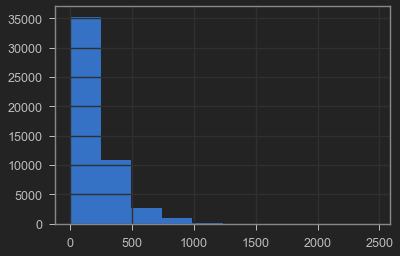

In [7]:
# Statistics of the reviews
reviews_len = [len(i.split()) for i in reviews]
print(pd.Series(reviews_len).describe())
pd.Series(reviews_len).hist()

In [8]:
print(len(reviews))
seq_length = 500
reviews = [" ".join(i.split()[:seq_length]) if (len(i.split()) >= seq_length) else i for i in reviews]

50000


In [9]:
reviews_vec = []
count = 0
for i in reviews:
    count += 1
    reviews_vec.append([vocab_to_int[word] for word in i.split()])

In [10]:
# Pad the sequence
reviews_int = []
for i in reviews_vec:
    review_len = len(i)
    if review_len != seq_length:
        reviews_int.append(list((np.zeros(seq_length - review_len))) + i)
    else:
        reviews_int.append(i)

In [11]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(np.array(reviews_int), labels
                                                                , test_size = 0.25, random_state = 0)

In [12]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
vocab_size = len(vocab_to_int.keys()) + 1

(37500, 500) (37500,) (12500, 500) (12500,)


In [13]:
learning_rate = 1e-04
opt = tf.keras.optimizers.Adam(lr = learning_rate)
embedded_length = 100
mask_val = 0
model = lstm_model(vocab_size, embedded_length, seq_length, mask_val)
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 500)               0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 100)          16275100  
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 16,436,101
Trainable params: 16,436,101
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
batch_size = 64
epochs = 50
mcp = tf.keras.callbacks.ModelCheckpoint("setiment.h5", monitor="val_accuracy", mode="max", save_best_only=True)    
history = model.fit(x_train, y_train, 
                    batch_size = batch_size, 
                    epochs = epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[mcp])

hist_df = pd.DataFrame(history.history)
hist_csv_file = r'history.csv'

with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Train on 37500 samples, validate on 12500 samples
Epoch 1/50
37500/37500 [==============================] - 138s 4ms/sample - loss: 0.5199 - accuracy: 0.7363 - val_loss: 0.3397 - val_accuracy: 0.8616
Epoch 2/50
37500/37500 [==============================] - 141s 4ms/sample - loss: 0.2632 - accuracy: 0.9022 - val_loss: 0.2982 - val_accuracy: 0.8846
Epoch 3/50
37500/37500 [==============================] - 139s 4ms/sample - loss: 0.1841 - accuracy: 0.9364 - val_loss: 0.2638 - val_accuracy: 0.8905
Epoch 4/50
37500/37500 [==============================] - 136s 4ms/sample - loss: 0.1385 - accuracy: 0.9540 - val_loss: 0.2848 - val_accuracy: 0.8917
Epoch 5/50
37500/37500 [==============================] - 129s 3ms/sample - loss: 0.0964 - accuracy: 0.9702 - val_loss: 0.2829 - val_accuracy: 0.8870
Epoch 6/50
 4352/37500 [==>...........................] - ETA: 2:09 - loss: 0.0637 - accuracy: 0.9823WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


KeyboardInterrupt: 

In [20]:
# Code to test the model

i = 500
print(reviews[i])
print("\n\n", labels[i])

what an empty and lack lustre rendition of the classic novel i do wish people would stop messing about with classics when they clearly have no idea of the real intention or point of the original this version is no different i felt that the ralph fiennes version is much worse though as the casting of juliette brioche as kathy has got to be the worst casting decision everanyway back to this version it aims to make the story relevant to a contemporary setting and in a musical style it succeeds in both but high art it is nit throwaway viewing for a rainy day maybethe direction was average and the editing abysmal worse than the old quincy deepak verma does a great turn as hindley and is in fact one of britains wasted talents the part of heath was played with great charm and belief and i think that the casting is the strongest point of this project although a more talented director would have made better use of the facilities he had its clear that he was a director for hire and did not insti

In [16]:
text = reviews[i].replace("<br />", "").lower().strip()
text = [vocab_to_int[word] for word in text.split()]
if (len(text) >= seq_length):
    text = [" ".join(text.split()[:seq_length])]
    
else:
    text = list(np.zeros(seq_length - len(text))) + text
    
text = np.array(text)

In [17]:
out = model.predict(np.expand_dims(text, axis=0))

In [18]:
thresh = 0.5
if out < thresh:
    print("The sentiment is : Negative")
else:
    print("The sentiment is : Positive")

The sentiment is : Negative
